# Analyse exploratoire et prise en main du dataset SuFoSaT

## Description du dataset

Le dataset est librement accessible en ligne sous la forme de deux fichiers image TIFF à l'adresse suivante : https://zenodo.org/records/13685177
La publication scientifique correspondante peut être lue à l'adresse suivante : https://ieeexplore.ieee.org/document/10604724

### Cartographie des dates
Le fichier correspondant est 'mosaics_tropisco_warnings_france_date.tif'. Ce fichier cartographie les coupes rases en fonction de leur date. La date est exprimée comme le nombre de jour écoulés depuis la date de lancement de la mission Sentinel-1A (03/04/2014 et non pas 03/04/2024 comme indiqué erronément sur la page Zenodo). Par exemple, un pixel couvrant une zone ayant subi une coupe rase le 03/04/2015 aura une valeur de 365.

Pour la version 2.0, les données couvrent une fenêtre temporelle allant de 2018 à août 2024. Les pixels ayant une valeur égale à 0 doivent donc être interprétés comme des pixels sans coupe rase détectée (et non une coupe rase ayant eu lieu à la date de lancement de Sentinel-1A).

### Cartographie des probabilités
Le fichier correspondant est 'mosaics_tropisco_warnings_france_prob.tif'. Ce fichier cartographie les coupes rases en fonction de leur probabilité. La probabilité est exprimée comme un entier entre 0 et 100 (équivalent donc à un pourcentage).

## Analyse exploratoire

In [1]:
# from __future__ import annotations  # required for the TYPE_CHECKING section to work for type hints

import contextily as cx
import geopandas as gpd
import numpy as np
import rioxarray
import shapely
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
from pathlib import Path
from rasterio.crs import CRS
# from typing import TYPE_CHECKING

# if TYPE_CHECKING:
#     import xarray

In [2]:
# geom_aqui = gpd.read_file("aquitaine.geojson")
# gdf_aqui_bbox = gpd.GeoDataFrame(geometry=[shapely.box(*geom_aqui.loc[0].geometry.bounds)], crs="WGS84")

Nous chargeons les géométries représentant les communes d'Aquitaine dans un GeoDataFrame, à partir duquel nous déterminons une bounding box

Nous isolons la valeur d'index associée à notre commune d'étude, Saint-Vincent-Jalmoutiers

In [3]:
geom_communes_aqui = gpd.read_file("communes-nouvelle-aquitaine.geojson")
idx_st_vincent = geom_communes_aqui.loc[geom_communes_aqui.nom == "Saint-Vincent-Jalmoutiers"].index[0]
geom_st_vincent = geom_communes_aqui.loc[idx_st_vincent].geometry
commune_bounds = geom_st_vincent.bounds
gdf_commune = geom_communes_aqui[geom_communes_aqui.nom.str.contains("Jalmoutiers")]  # Utilisé pour dessiner les limites de la commune

Nous chargeons la cartographie par date à l'aide de la librarie 'rioxarray'. Nous nous limitons à la bounding box contenant la commune choisie précédemment.

In [4]:
# xda_date = rioxarray.open_rasterio("mosaics_tropisco_warnings_france_date.tif", chunks="auto")
xda_date = rioxarray.open_rasterio("mosaics_tropisco_warnings_france_date.tif")
xda_date = xda_date.rio.clip_box(*commune_bounds)

In [5]:
xda_date

<xarray.DataArray (band: 1, y: 553, x: 532)> Size: 588kB
[294196 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 0.1655 0.1656 0.1657 ... 0.2289 0.229 0.2291
  * y            (y) float64 4kB 45.21 45.21 45.21 45.21 ... 45.16 45.16 45.16
    spatial_ref  int64 8B 0
Attributes:
    long_name:          *
    processor-version:  1.1.8
    AREA_OR_POINT:      Area
    scale_factor:       1.0
    add_offset:         0.0
    _FillValue:         0

Nous dessinons un histogramme des pixels de date des coupes rases sur la commune afin d'avoir une idée de leur distribution (cette opération peut prendre du temps sur une surface plus conséquente car c'est ici que les données de l'image sont effectivement lues et agrégées pour créer le graphe)

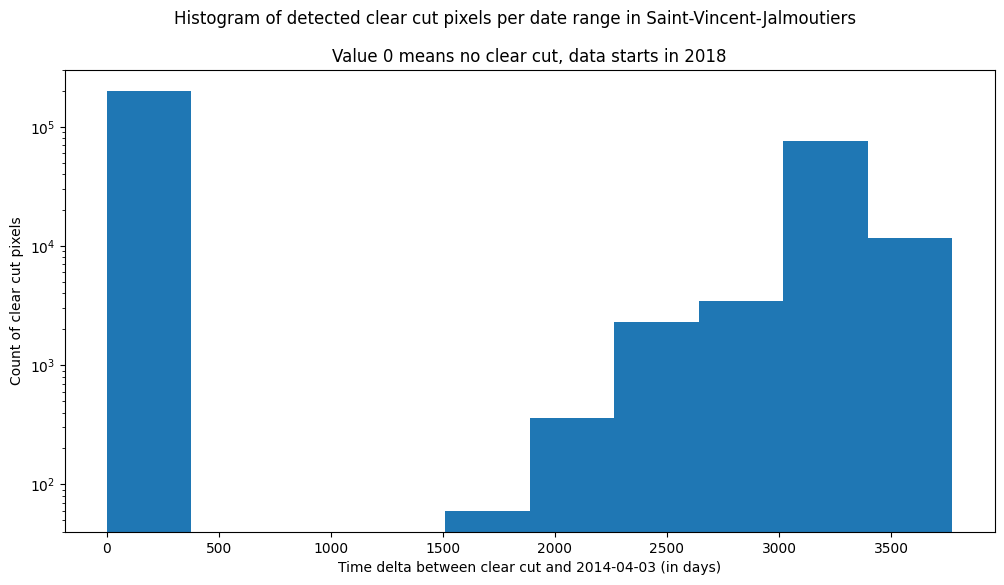

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
xda_date.plot.hist(yscale="log", ax=ax)
ax.set_xlabel("Time delta between clear cut and 2014-04-03 (in days)")
ax.set_ylabel("Count of clear cut pixels")
ax.set_title("Value 0 means no clear cut, data starts in 2018")
fig.suptitle("Histogram of detected clear cut pixels per date range in Saint-Vincent-Jalmoutiers")
plt.show()

Nous définissons une paire de fonctions qui nous permettent de filtrer les données appartenant à une certaine fenêtre temporelle. En pratique, cela signifie que les pixels non-nuls mais représentant une date d'alerte située hors de la fenêtre temporelle sont fixés à 0

In [7]:
def timerange_to_tropisco(timerange: tuple[datetime | date, datetime | date]) -> tuple[int, int]:
    """Converts a datetime-like timerange into a timerange expressed as numbers of days elapsed since the reference date (04/03/2014).

    Parameters
    ----------
    timerange: tuple[datetime | date, datetime | date]
        The datetime-like timerange to convert into numbers of days since the reference date.

    Returns
    -------
    tropisco_timerange: tuple[int, int]
        The timerange expressed as numbers of days since the reference date.
    """
    
    if (timerange[1] - timerange[0]).days < 0:
        raise ValueError("Timerange delta is negative ; timerange should be written as (earliest_date, latest_date).")
    ref_date = datetime(2014, 4, 3)
    tropisco_timerange = ((timerange[0] - ref_date).days, (timerange[1] - ref_date).days)
    return tropisco_timerange

In [8]:
def filter_within_timerange(image, timerange: tuple[datetime | date, datetime | date]):
# def filter_within_timerange(image: xarray.DataArray, timerange: tuple[datetime | date, datetime | date]) -> xarray.DataArray:
    """Filters the pixels whose date is outside of the provided timerange by setting them to zero.

    Parameters
    ----------
    image: xarray.DataArray
        The date-based alert image to filter.
    timerange: tuple[datetime | date, datetime | date]
        The timerange of interest.

    Returns
    -------
    masked_image: xarray.DataArray
        The masked image so that only pixels within the provided timerange are non-zero.
    """
    
    trop_t_start, trop_t_stop = timerange_to_tropisco(timerange)
    masked_image = xda_date.where((xda_date >= trop_t_start) & (xda_date < trop_t_stop), 0)
    return masked_image

In [9]:
timerange = (datetime(2024, 5, 30), datetime(2024, 6, 30))
masked_xda_date = filter_within_timerange(xda_date, timerange)

Nous re-dessinons l'histogramme précédent et constatons que seuls des pixels de l'année 2024 persistent après notre opération de filtrage/masque

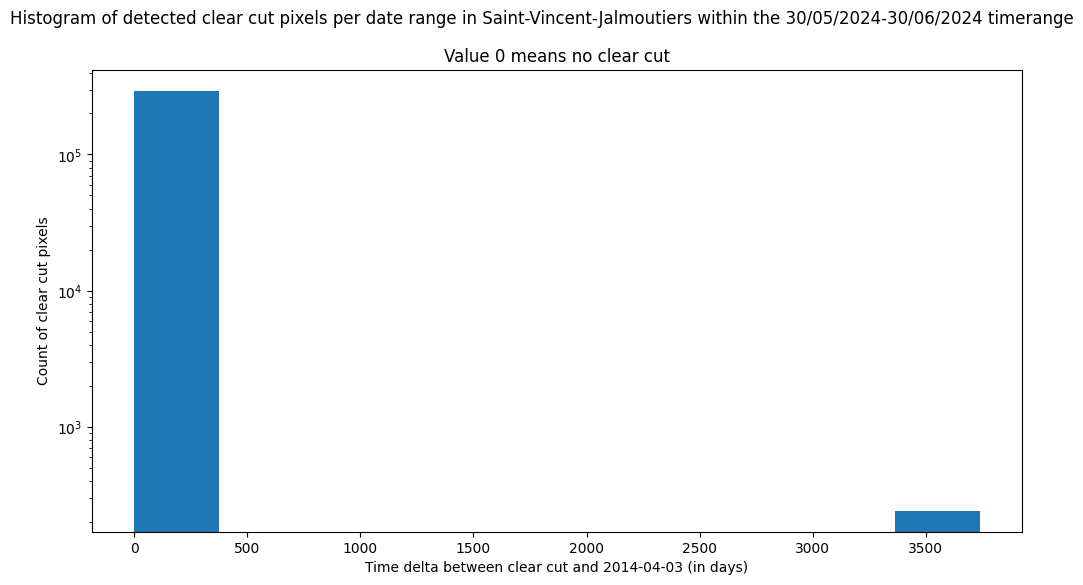

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
masked_xda_date.plot.hist(yscale="log", ax=ax)
ax.set_xlabel("Time delta between clear cut and 2014-04-03 (in days)")
ax.set_ylabel("Count of clear cut pixels")
ax.set_title("Value 0 means no clear cut")
fig.suptitle("Histogram of detected clear cut pixels per date range in Saint-Vincent-Jalmoutiers within the 30/05/2024-30/06/2024 timerange")
plt.show()

Nous nous intéressons maintenant à la cartographie des probabilités. Nous commencons par ouvrir l'image correspondante

In [11]:
# xda_prob = rioxarray.open_rasterio("mosaics_tropisco_warnings_france_prob.tif", chunks="auto")
xda_prob = rioxarray.open_rasterio("mosaics_tropisco_warnings_france_prob.tif")
xda_prob = xda_prob.rio.clip_box(*commune_bounds)

En dessinant l'histogramme des probabilités des pixels de coupes rases détectées, nous observons qu'ils ont tous une valeur de probabilité supérieure ou égale à 90%. Un seuil a probablement été fixé pour filtrer les pixels avec une probabilité inférieure, mais cela reste à confirmer sur un ensemble plus grand (hypothèse confirmée sur la région Aquitaine entière, à confirmer sur notre territoire d'intérêt qui est la France).

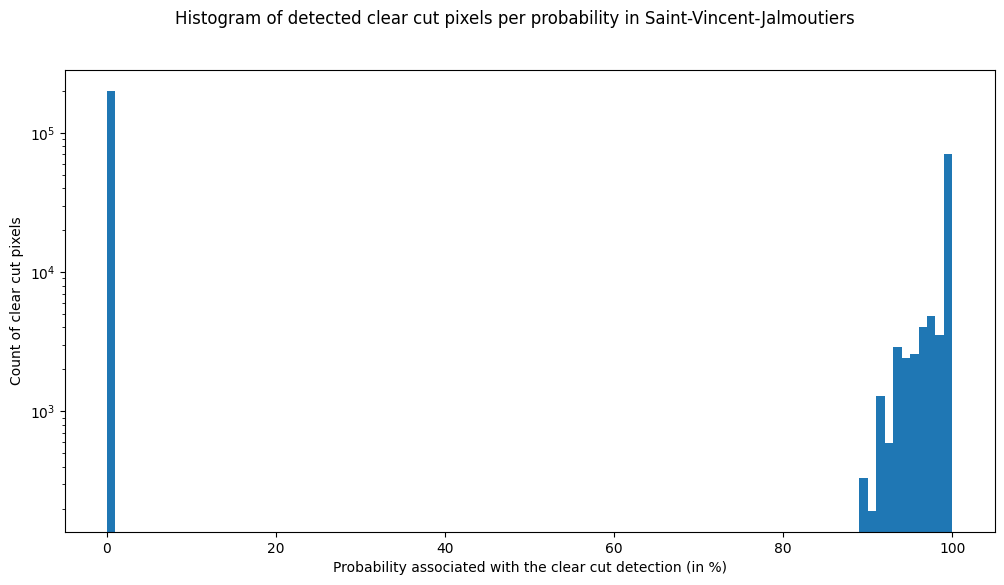

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
xda_prob.plot.hist(yscale="log", bins=100)
ax.set_xlabel("Probability associated with the clear cut detection (in %)")
ax.set_ylabel("Count of clear cut pixels")
ax.set_title("")
fig.suptitle("Histogram of detected clear cut pixels per probability in Saint-Vincent-Jalmoutiers")
plt.show()

Le niveau de probabilité peut être utilisé pour filtrer les alertes avec un seuil de niveau de confiance. Le seuil étant apparemment déjà fixé à 90%, cela ne nous semble pas nécessaire. Néanmoins nous proposons une fonction permettant de créer un masque correspondant à un intervalle de probabilité voulu par l'utilisateur

In [13]:
def build_mask_from_prob_range(prob_image, prob_range: tuple[int, int]):
# def build_mask_from_prob_range(prob_image: xarray.DataArray, prob_range: tuple[float, float]) -> xarray.DataArray:
    prob_min, prob_max = prob_range
    partial_mask_prob = prob_image.where((prob_image >= prob_min) & (prob_image < prob_max), -1)
    partial_mask_prob = partial_mask_prob.where(partial_mask_prob == -1, 1)
    final_mask_prob = partial_mask_prob.where(partial_mask_prob != -1, 0)
    return final_mask_prob

In [14]:
mask_prob = build_mask_from_prob_range(xda_prob, (95, 100))

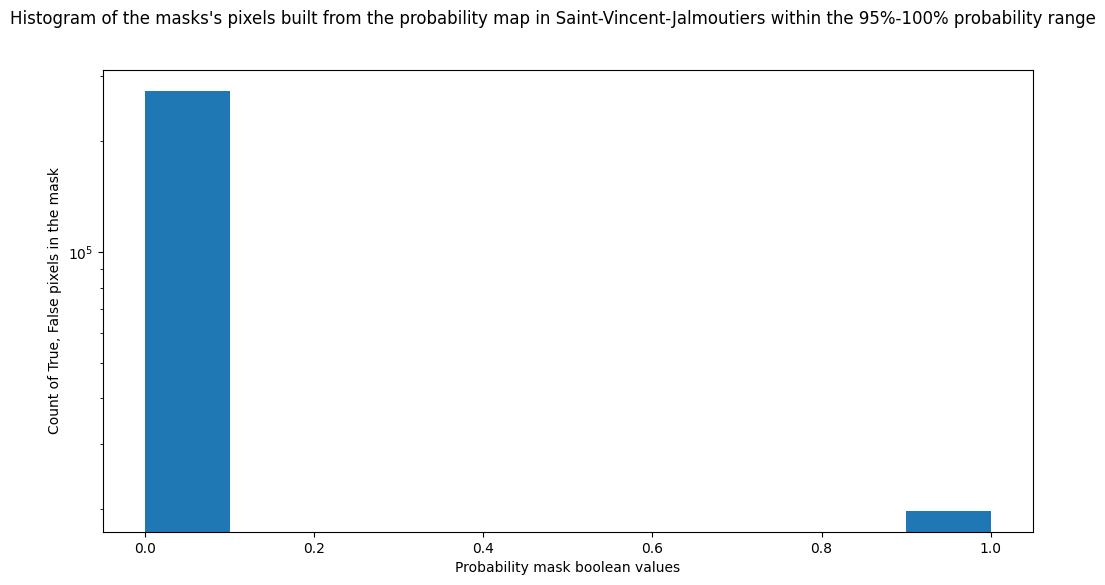

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
mask_prob.plot.hist(yscale="log")
ax.set_xlabel("Probability mask boolean values")
ax.set_ylabel("Count of True, False pixels in the mask")
ax.set_title("")
fig.suptitle("Histogram of the masks's pixels built from the probability map in Saint-Vincent-Jalmoutiers within the 95%-100% probability range")
plt.show()

In [16]:
west, south, east, north = commune_bounds
map_img, map_ext = cx.bounds2img(west, south, east, north, ll=True, source=cx.providers.CartoDB.Voyager)

Nous dessinons finalement la carte des coupes rases sur le territoire de la commune de Saint-Vincent-jalmoutiers. Nous observons que malgré des étapes de coupes distinctes dans le temps, deux coupes rases étendues ont été réalisées chacune sur un période temporelle limitée (couleurs orange et corail)

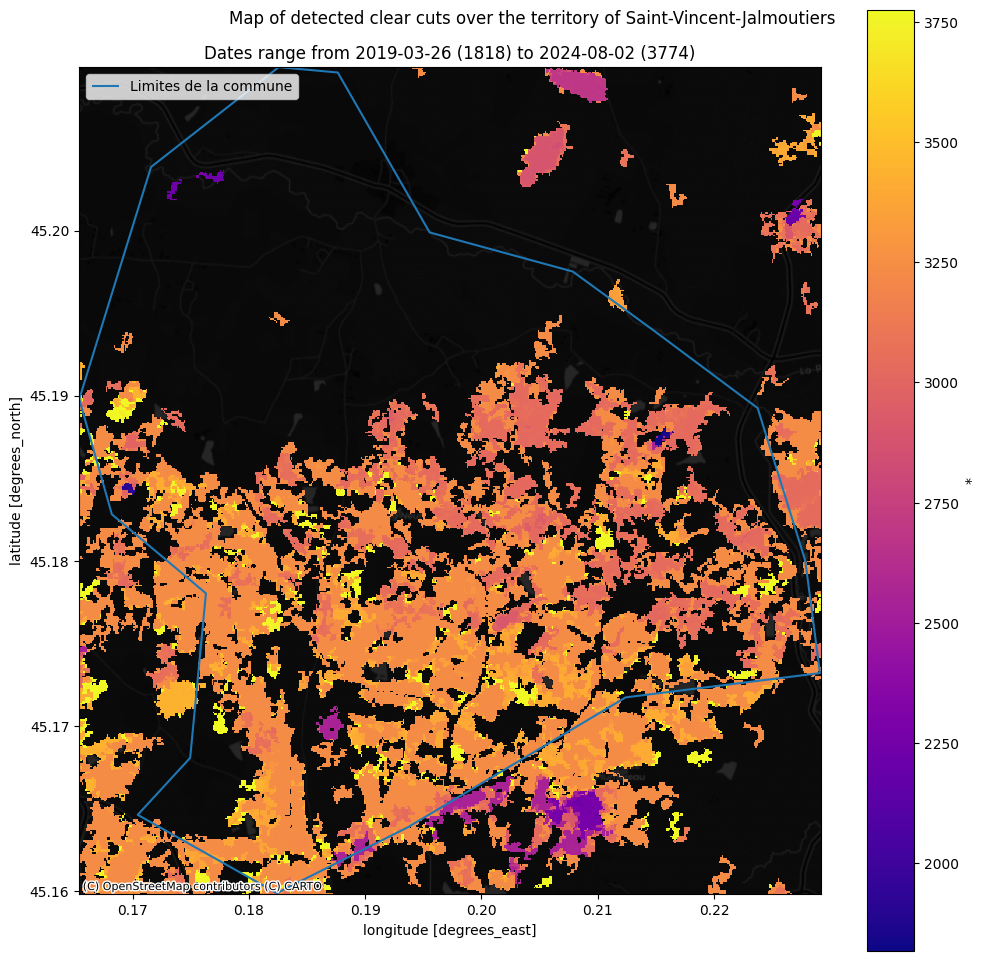

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.tight_layout()
xda_date_nozero = xda_date.where(xda_date > 0, np.nan)
xda_date_nozero.plot(ax=ax, cmap="plasma")
gdf_commune.boundary.plot(ax=ax, label="Limites de la commune")
cx.add_basemap(ax, crs="WGS84", source="CartoDB.DarkMatter")
fig.suptitle("Map of detected clear cuts over the territory of Saint-Vincent-Jalmoutiers")
t_min, t_max = int(xda_date_nozero.min().values), int(xda_date_nozero.max().values)
date_min, date_max = datetime(2014,4,3) + timedelta(t_min), datetime(2014,4,3) + timedelta(t_max)
ax.set_title(f"Dates range from {date_min.date()} ({t_min}) to {date_max.date()} ({t_max})")
ax.legend(loc="upper left")
plt.show()